In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Reshape,Dense,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

#Data

In [ ]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


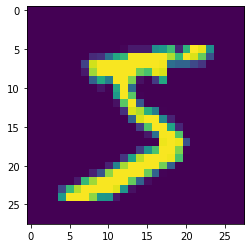

In [ ]:
plt.imshow(X_train[0])

In [ ]:
print(X_train.shape)
print(X_train[0])
print(y_train.shape)
print(y_train[0])
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 25

In [ ]:
# All the intensity values are from 0 to 255
#Note:  We will use tanh function for the last layer of the Generator so, 
# So in the discriminator model of the X-train we need to rescale the input matrix to (-1 to 1) 

In [ ]:
print(X_train.min())
print(X_train.max())
X_train = X_train/255
X_train = X_train.reshape(-1,28,28,1)*2.0-1.0
print(X_train.min())
print(X_train.max())

0
255
-1.0
1.0


In [ ]:
# Training the model for y=0

only_zeros = X_train[y_train==0]
print(only_zeros.shape)

(5923, 28, 28, 1)


In [ ]:
np.random.seed(101)
tf.random.set_seed(101)
codings_size = 100

In [ ]:
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",activation="tanh"))

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.3),input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [ ]:
GAN = Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [ ]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [ ]:
batch_size = 32
my_data = only_zeros
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
epochs = 20

In [ ]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

In [ ]:
noise = tf.random.normal(shape=[10, codings_size])

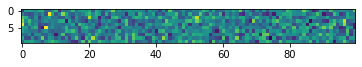

In [ ]:
plt.imshow(noise)

(10, 28, 28, 1)


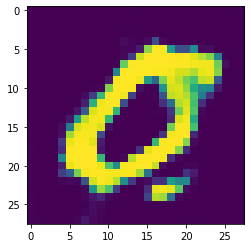

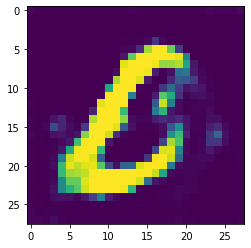

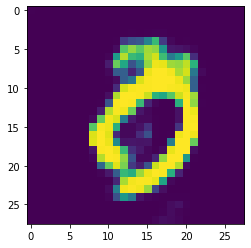

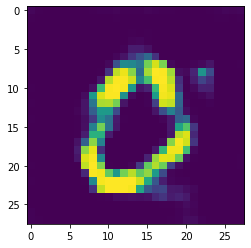

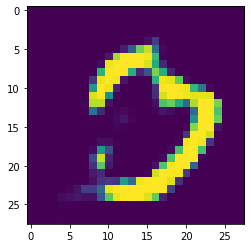

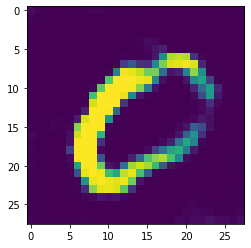

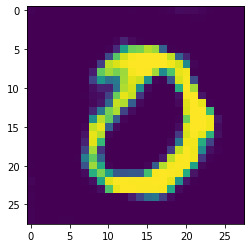

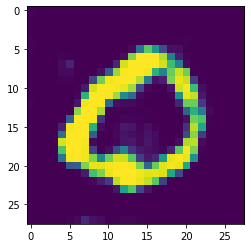

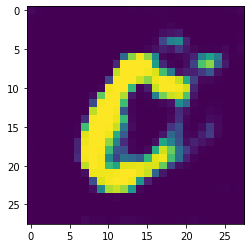

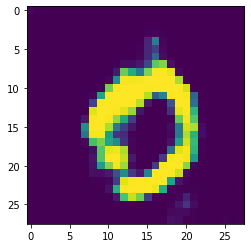

In [ ]:
noise = tf.random.normal(shape=[10, codings_size])
images = generator(noise)
print(images.shape)
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()

In [ ]:
#This is an example with 0 we can do the same with any digit